<a href="https://colab.research.google.com/github/yonatanrtt/sentiment-analysis/blob/main/P_f1_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><h1> Intro </h1>
this project demonstrates a problem from the nlp world.

<b><h1> the problem </h1>
classify each IMDB movie review as positive or negative <br/>
the input is a movie or tv series review and the output will be positive or negative classification.


<b><h1> motivation </h1>
classification of natural language text to positive and negative can help in many fields, for example:

- many sites have comment section, if the company wants to see how many bad comments they get for having better understanding of reasons behind it, the first thing will be to classify the comments for positive \ negative

- many sites have comment section for every item, the nuber of positive comments for an item can be used as a feature for recommender system.

- many sites (like facebook) try to find inappropriate and offensive posts. this is a different task but I belive this project will be similar, and this task might help solve the second task 

<b><h1> data </h1>
imdb reviews. <br/>
25K of positive reviews. <br/>
25K of negative reviews. <br/> <b>

<b><h2><b>EDA - exploratory data analysis</b></h2>

In this notebook, the data will be explored</b>

In [ ]:
# import packages
import pandas as pd
import re
from math import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from google.colab import  drive
drive.mount("/drive")
all_data = pd.read_csv("/drive/My Drive/data.csv")

Mounted at /drive


<b><h3>First Step:</h3>

for every category exploring the reviews length stats </b>

In [ ]:
def print_graph(p, n, a, features):
    positive_vec = [p[f] for f in features]
    negative_vec = [n[f] for f in features]
    all_vec = [a[f] for f in features]
    
    # create data
    x = np.arange(len(features))
    width = 0.2

    plt.figure(figsize=(20,5))
    # plot data in grouped manner of bar type
    plt.bar(x-0.2, positive_vec, width, color='blue')
    plt.bar(x + 0, negative_vec, width, color='maroon')
    plt.bar(x + 0.2, all_vec, width, color='orange')
    plt.xticks(x, features)
    plt.xlabel("")
    plt.ylabel("")
    plt.legend(["Positive", "Negative", "all"])
    plt.show()

In [ ]:
# filter data by type
def filter_data(type):
    return pd.DataFrame(all_data[all_data["sentiment"]==type]["review"])

In [ ]:
positive = filter_data("positive")
negative = filter_data("negative")
all_data = pd.concat([positive, negative])

<b>review length will be defined by the number of words it contains

In [ ]:
# create df by txt lenth only
positive_len = positive.applymap(lambda x: len(str(x).split(" ")))
negative_len = negative.applymap(lambda x: len(str(x).split(" ")))
all_data_len = all_data.applymap(lambda x: len(str(x).split(" ")))

In [ ]:
def print_stats(df):
    return dict(mean=df.mean()[0], sum=df.sum()[0], median=df.median()[0], count=df.count()[0], std=df.std()[0])

In [ ]:
positive_len_stats = print_stats(positive_len)
negative_len_stats =print_stats(negative_len)
all_len_stats = print_stats(all_data_len)

<b>print on one graph the mean and the median of the reviews length of every category and of the entire data <br/> <br/>
if there's a large difference between the columns it might suggest that the length is a good feature for the vector that will represent the text <br/> <br/> 
if one of the category has much larger std than the other one it might change the the understanding of the mean and median</b>

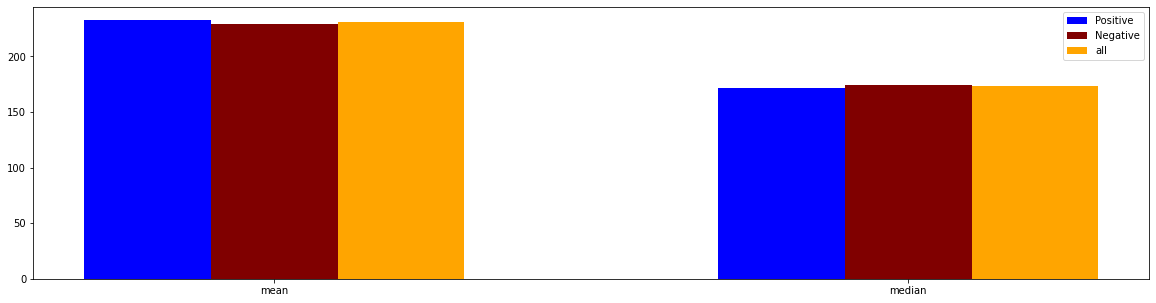

In [ ]:
print_graph(positive_len_stats, negative_len_stats, all_len_stats, ["mean", "median"])

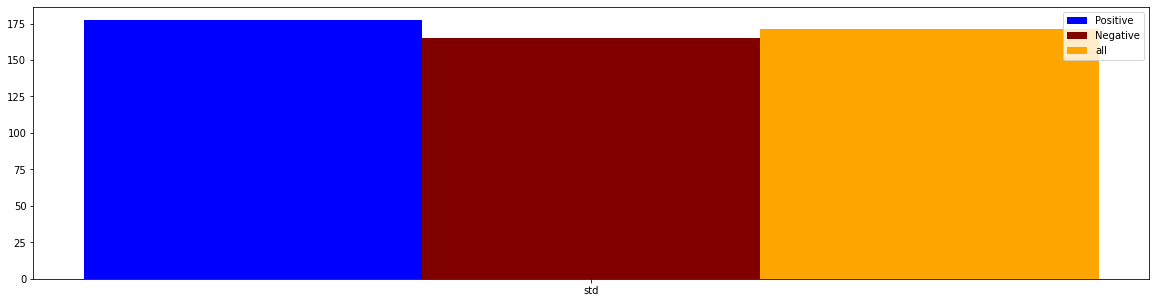

In [ ]:
print_graph(positive_len_stats, negative_len_stats, all_len_stats, ["std"])

<b><h3>conclusion for the first step</h3>
it seems like the reviews lenth is almost the same at all of the categories, so it does not give a lot of inforamtion for the classification</b>

<b><h3>Second Step:</h3>
exploring the words stats <br/>

one of the most important factors that inﬂuences the model in nlp is the preprocessing. <br/>
one of the most important factors of good preprocessing in the world of nlp is cleaning the text <br/>
in the EDA and in the rest of the project it will be done using the following: <br/> 
- change new line by html to word <br/>
- remove all other html tags <br/>
- remove the spaces before and after the text <br/>
- change all text ( english language only ) to lower case <br/>
- separate punctuation from words <br/>
- remove digits <br/>
- remove unneed spaces <br/>

in addition to cleaning the text, stop words will be removed. <br/>
stop words are a list of some of the most common words in the language. removing those words will help the model focus on more important features.</b>

In [ ]:
def clean_text(txt):
    
    # set new line as a word
    txt = re.sub(r'<br />', " enter ", txt)  
    txt =re.sub(r'<br/>', " enter ", txt)

    # remove all other hatml tags
    txt = re.sub(r'<.*?>', ' ', txt)
    
    # set all text as lower case
    txt = txt.strip().lower()
    
    # separate specific characters like punctuation from words for using word base algorithms
    special_chars = '!"\/#$%&()*+,-./:;<=>?@[]^_`{|}~'
    special_chars_dict = dict((c, " " + c + " ") for c in special_chars)
    str_map = str.maketrans(special_chars_dict)
    txt = txt.translate(str_map)
    
    # remove digits and spaces
    all_words = [word for word in txt.split(sep = " ") if not word.isdigit()]
    all_words_not_spaces = filter(lambda item: item, all_words)
    txt = ' '.join(all_words_not_spaces)
    txt = txt.strip()
    
    return txt

In [ ]:
# print stats by words
def word_freq_handler(vec, df, is_couner):
    all_words = vec.transform(df)
    words_sum = all_words.sum(axis=0) 
    words_freq = [(word, words_sum[0, idx]) for word, idx in  vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1])
    df_wf = pd.DataFrame(words_freq, columns=["word", "freq"])
    counter = df_wf.iloc[:,1]
    used_single_time = counter[counter==1]
    data = dict()
    if is_couner == True:
        data = dict(mean=counter.mean(), sum=counter.sum(), median=counter.median(), 
                    count=counter.count(), std=counter.std(), used_single_time=len(used_single_time))
    else:
        data = dict(mean=counter.mean(), sum=counter.sum(), median=counter.median(), 
                    count=counter.count(), std=counter.std())
    data["words_freq"] = df_wf
    return data

In [ ]:
def print_word_freq(df, obj):
        df = df["review"]
        vec_counter = CountVectorizer(stop_words="english", preprocessor=clean_text).fit(df)
        vec_tfidf = TfidfVectorizer(stop_words="english", preprocessor=clean_text).fit(df)
        obj["counter"] = word_freq_handler(vec_counter, df, True)
        obj["tfidf"] = word_freq_handler(vec_tfidf, df, False)

In [ ]:
positive_stats = dict()
print_word_freq(positive, positive_stats)

negative_stats = dict()
print_word_freq(negative, negative_stats)

all_stats = dict()
print_word_freq(all_data, all_stats)

<b>words stats - taking all words of every review in every category and count them.
then print their stats on a graph.<br/><br/>

blue - positive - all the words in the positive reviews <br/>
red - negative - all the words in the negative reviews <br/>
orange - all - all words in all the reviews
<br/><br/>
for example: <br/>

median - positive - for all the words in the positive review, count for every word how many times it displayed in the *psotivie* reviews - return the median of this list</b>

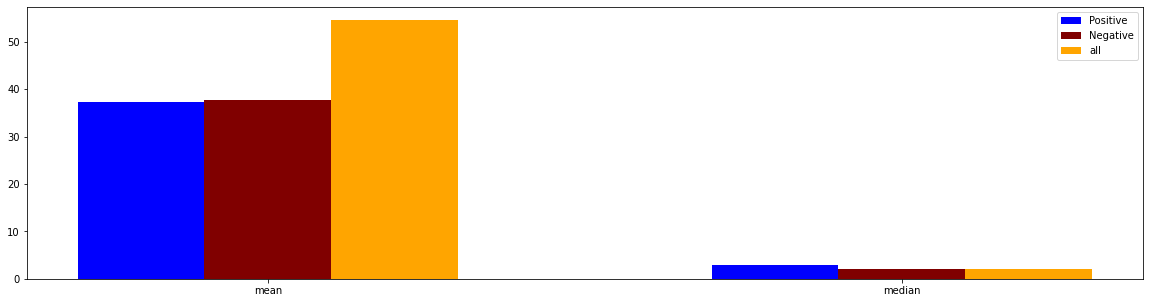

In [ ]:
print_graph(positive_stats["counter"], negative_stats["counter"], all_stats["counter"], ["mean", "median"])

<b><br/>
1. the mean is much much larger than the median, it might suggest the are many words that displaing once or almost one time only
<b>
2. it is interesting to note that mean of all reviews ( orange column ) is the highest column and the median of all reviews is the smallest column</b>

<b>the next graph will show the words counting std

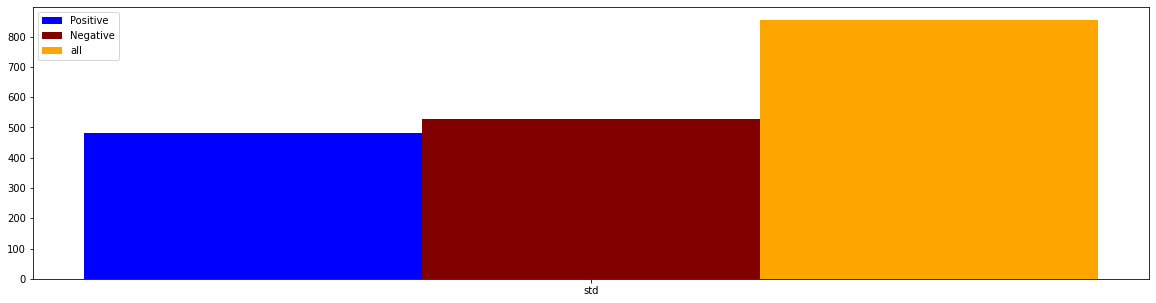

In [ ]:
print_graph(positive_stats["counter"], negative_stats["counter"], all_stats["counter"], ["std"])

<b>the problem with those graphs is that they are relying on counting only. <br/>
the next charts will use TF-IDF wich decreases decrease the importance of words that appear more frequently in general. 

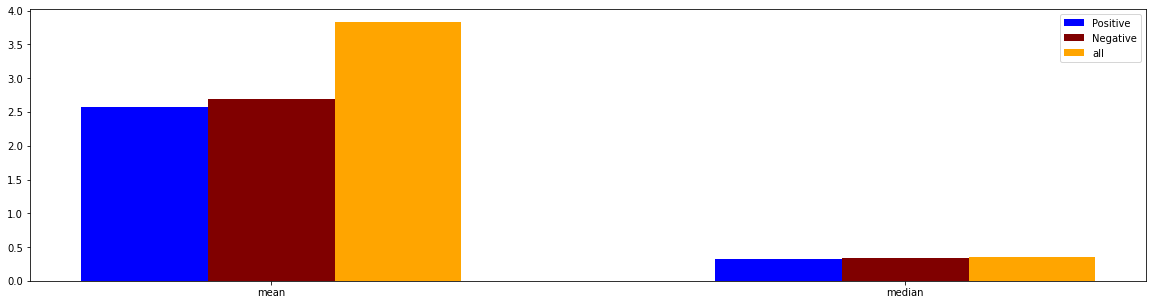

In [ ]:
print_graph(positive_stats["tfidf"], negative_stats["tfidf"], all_stats["tfidf"], ["mean", "median"])

<b>the next graph will show the words counting std

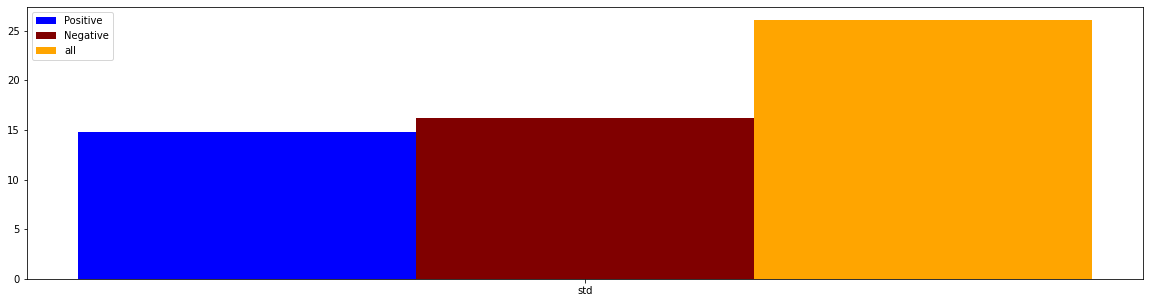

In [ ]:
print_graph(positive_stats["tfidf"], negative_stats["tfidf"], all_stats["tfidf"], ["std"])

<b>in the graph of the word counter stats - the median was very low<br/>
it was already noted above that the reason is the hogh number of words that appers only once <br/>
the next chart will show words that appears only once.
<br/><br/>
it is important to understand that word can be used one time only in the postive revies and one time only in the negative reviews, but over all it is used two times so it will not be counted in the all column

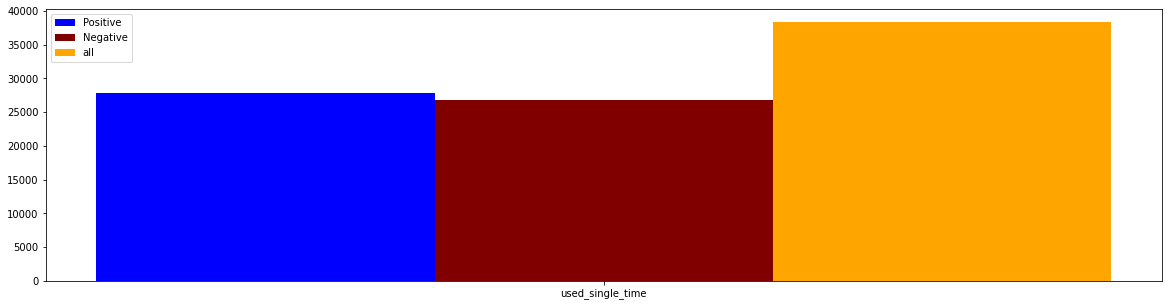

In [ ]:
print_graph(positive_stats["counter"], negative_stats["counter"], all_stats["counter"], ["used_single_time"])

<b><h3>conclusion for the second step</h3>

- the median of the counter and the TF-IDF are very low. it might suggest that removing a lot of the words from the text at the preproccessing part for avoiding overfitting is a good idea

- this conclusion is strengthened by the number of words that are used only once 

- one could think that there is a small group of reviews that are very different from the other and they change all of the stats. <br/>
the ratio between the column of all the stats in the counter section and in the tfidf section are very similar. <br/>
It suggest  the stars are stable. <br/>

<b><h3>Third Step:</h3>

exploring the most popular words for every category

In [ ]:
def set_df_top_words(df, words):
    df = df.loc[df['word'].isin(words)]
    diff = np.setdiff1d(words, df["word"]).tolist()
    diff_add = [{ "word" : i, "freq": 0 } for i in diff]
    df = df.append(diff_add, ignore_index=True)   
    df = df.sort_values("word", ascending=False, ignore_index=True)
    return df

In [ ]:
def print_graph(positive_vec, negative_vec, all_vec):    
    words = list(set(list(positive_vec[-10:].loc[:,"word"]) + list(negative_vec[-10:].loc[:,"word"]) + list(all_vec[-10:].loc[:,"word"])))
    positive_top_w = set_df_top_words(positive_vec, words)
    negative_top_w = set_df_top_words(negative_vec, words)
    all_top_w = set_df_top_words(all_vec, words)
    
    words.sort(reverse=True)

    # create data
    x = np.arange(len(words))
    width = 0.4

    plt.figure(figsize=(20,5))
    # plot data in grouped manner of bar type
    plt.bar(x-0.2, positive_top_w.loc[:,"freq"], width, color='blue')
    plt.bar(x + 0.2, negative_top_w.loc[:,"freq"], width, color='maroon')
    plt.xticks(x, words)
    plt.xlabel("Words")
    plt.ylabel("Freq")
    plt.legend(["Positive", "Negative"])
    plt.show()

<b>the next charts will show the stats of the most popular words in the reviews.<br/>
the most popular words were chosen as follow:
1. find the 10 most popular words in the positive reviws
2. find the 10 most popular words in the negative reviws
3. find the 10 most popular words in the over all reviws 


combine the three list into a common set

<b>the next chart will show the counting of the most popular words

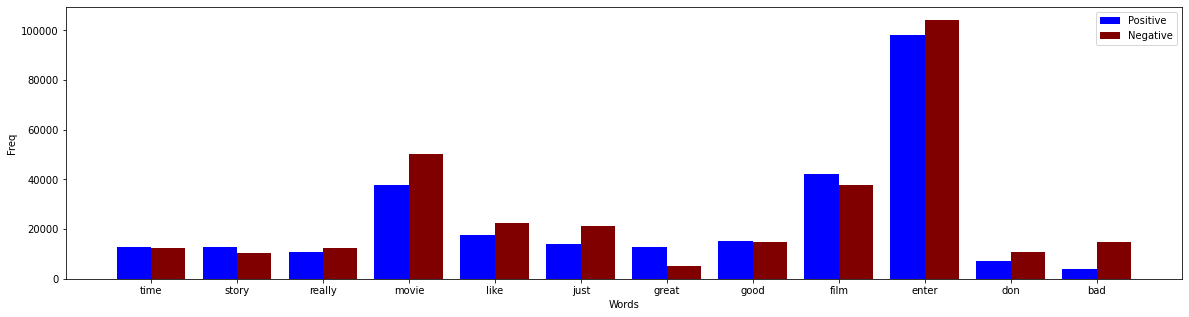

In [ ]:
print_graph(positive_stats["counter"]["words_freq"], 
            negative_stats["counter"]["words_freq"], all_stats["counter"]["words_freq"])

<b>the next chart will show the TF-IDF of the most popular words

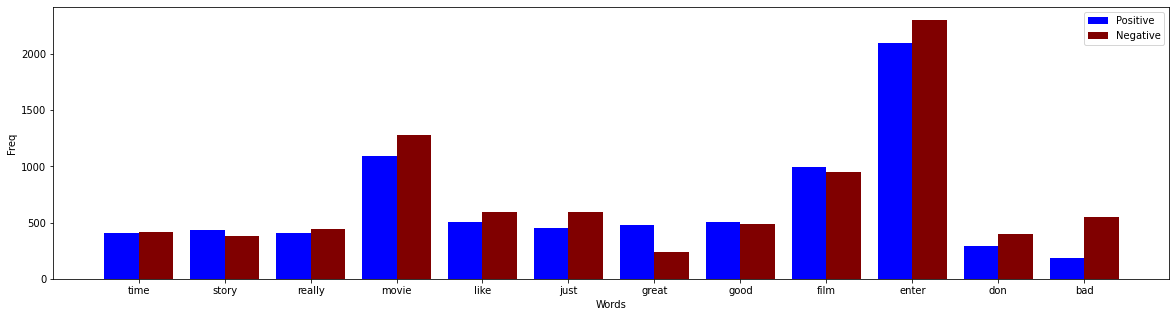

In [ ]:
print_graph(positive_stats["tfidf"]["words_freq"], 
            negative_stats["tfidf"]["words_freq"], all_stats["tfidf"]["words_freq"])

<b><h3>conclusion for the third step</h3>

- the size of the common set of the most popular words in only slightly bigger than the size of each list wich shows that a lot of popular words are used in both negative and positive reviews

- the same words came as the most popular in the counter and in the tf-idf

- it is interesting how many times the word "good" has been used in the negtive reviews. the reason is popular combinations like "not good", " it wasn't a good movie"...
